<a href="https://colab.research.google.com/github/Alizzie/ST_CA1/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import requests
import numpy as np
import tensorflow as tf
from pathlib import Path
import pickle
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
np.random.seed(0)

In [51]:
def download_datasets(url, dataset_name):
    path_to_zip = tf.keras.utils.get_file(
        fname=f"{dataset_name}.tar.gz",
        origin=url,
        extract=True)

    path_to_zip = Path(path_to_zip)
    path = path_to_zip.parent / dataset_name
    return path_to_zip, path

In [52]:
# Copy from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [53]:
def extract_cifar10_batches(batch_dic):
    batch_labels = batch_dic.get(b'labels')
    batch_images = batch_dic.get(b'data')
    batch_filenames = batch_dic.get(b'filenames')
    return batch_labels, batch_images, batch_filenames

In [54]:
def extract_cifar100_batches(batch_dic):
    fine_labels = batch_dic.get(b'fine_labels')
    coarse_labels = batch_dic.get(b'coarse_labels')
    images = batch_dic.get(b'data')
    filenames = batch_dic.get(b'filenames')
    return fine_labels, coarse_labels, images, filenames

In [55]:
def get_classes_dic(key, class_names, dic):
    labels = dic.get(key)
    labels = list(map(lambda x: x.decode('utf-8'), labels))
    labels_nr = [index for index, value in enumerate(labels) if value in class_names]
    labels =  [value for _, value in enumerate(labels) if value in class_names]
    return labels, labels_nr

In [56]:
def filter_class(classes, labels, images, filenames):
    filtered_labels = [label for label in labels if label in classes]
    filtered_images = []
    filtered_filenames = []

    for i in range(len(labels)):
        if labels[i] in classes:
            filtered_images.append(images[i])
            filtered_filenames.append(filenames[i])

    return np.array(filtered_labels), np.array(filtered_images), np.array(filtered_filenames)

In [57]:
def group_fine_with_superclass(new_index, f_labels, c_labels, selected_fine_classes, new_val):
    selected_fine_classes.append(new_index)

    for i in range(len(f_labels)):
        f_labels[i] = new_index if c_labels[i] == new_val else f_labels[i]

    return f_labels

In [58]:
def get_data(batchnames, batch_size, path,needed_classes, with_superclass = False, needed_superclass = []):
    data_labels = []
    data_images = []
    data_filenames = []
    data_superclass = []

    for name in batchnames:
        batch_dic = unpickle(str(path / name))

        if with_superclass:
            labels, coarse_labels, images, filenames = extract_cifar100_batches(batch_dic)
            data_superclass.extend(coarse_labels)
        else:
            labels, images, filenames = extract_cifar10_batches(batch_dic)

        data_labels.extend(labels)
        data_images.extend(images)
        data_filenames.extend(filenames)
        assert((images.shape[1] == 3072)), 'images are not in 3072 bytes'


    assert((len(data_images) == batch_size)), f'images contains not all {batch_size} images'
    assert((len(data_filenames) == batch_size)), f'filenames contains not all {batch_size} filenames'

    if with_superclass:
        assert((len(data_labels) == batch_size)), f'fine labels contains not all {batch_size} labels'
        assert((len(coarse_labels) == batch_size)), f'coarse labels contains not all {batch_size} labels'

        # Only one needed superclass
        for i in range(len(needed_superclass)):
            data_labels = group_fine_with_superclass(((i+1) * -1), data_labels, coarse_labels, needed_classes, needed_superclass[i])
        data_labels, data_images, data_filenames = filter_class(needed_classes, data_labels, data_images, data_filenames)
    else:
        assert((len(data_labels) == batch_size)), f'labels contains not all {batch_size} labels'
        data_labels, data_images, data_filenames = filter_class(needed_classes, data_labels, data_images, data_filenames)

    return data_labels, data_images, data_filenames


In [59]:
def remap_labels(labels, start_step = 0):
    label_mapping = {label: index + start_step for index, label in enumerate(sorted(set(labels)))}
    labels = [label_mapping[label] for label in labels]
    return labels

In [60]:
def merge_datasets(labels1, labels2, images1, images2):
    print(len(labels1), len(labels2))
    x_data = np.concatenate([images1, images2], axis=0)
    y_data = np.concatenate([labels1, labels2], axis=0)
    print(len(x_data), len(y_data))
    print(set(y_data), len(set(y_data)))
    return x_data, y_data

In [61]:
cifar10_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar100_url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
zip, cifar10_path = download_datasets(cifar10_url, 'cifar-10-batches-py')
zip, cifar100_path = download_datasets(cifar100_url, 'cifar-100-python')

In [62]:
# class_labels: 1, 2, 3, 4, 5, 7, 9
dic_file = 'batches.meta'
needed_cifar10_classes = ['automobile', 'bird',  'cat', 'deer', 'dog', 'horse', 'truck']
cifar10_dic = unpickle(str(cifar10_path / dic_file))
selected_cifar10_classnames, selected_cifar10_classes = get_classes_dic(b'label_names', needed_cifar10_classes, cifar10_dic)
print(selected_cifar10_classnames)
print(selected_cifar10_classes)

['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'truck']
[1, 2, 3, 4, 5, 7, 9]


In [63]:
# Cifar 100
needed_cifar100_fine_classes = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck',
                                'train', 'lawn_mower', 'tractor']
needed_cifar100_superclasses = ['trees']

cifar100_dic = unpickle(str(cifar100_path / 'meta'))
keys_list = list(cifar100_dic.keys())

selected_cifar100_fine_classnames, selected_cifar100_fine_classes = get_classes_dic(keys_list[0], needed_cifar100_fine_classes, cifar100_dic)
print(selected_cifar100_fine_classnames, selected_cifar100_fine_classes)

selected_cifar100_superclassnames, selected_cifar100_superclasses = get_classes_dic(keys_list[1], needed_cifar100_superclasses, cifar100_dic)
print(selected_cifar100_superclassnames, selected_cifar100_superclasses)

['baby', 'bicycle', 'boy', 'bus', 'cattle', 'fox', 'girl', 'lawn_mower', 'man', 'motorcycle', 'pickup_truck', 'rabbit', 'squirrel', 'tractor', 'train', 'woman'] [2, 8, 11, 13, 19, 34, 35, 41, 46, 48, 58, 65, 80, 89, 90, 98]
['trees'] [17]


In [64]:
#Cifar10 Train data
batchnames = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
cifar10_labels, cifar10_images, cifar10_filenames = get_data(batchnames, 50000, cifar10_path, selected_cifar10_classes)

# Cifar10 Test data
cifar10_test_labels, cifar10_test_images, cifar10_test_filenames = get_data(['test_batch'], 10000, cifar10_path, selected_cifar10_classes)

# Cifar100 Train data
cifar100_labels, cifar100_images, cifar100_filenames  = get_data(['train'], 50000, cifar100_path, selected_cifar100_fine_classes, True, selected_cifar100_superclasses)

# Cifar100 Test data
cifar100_test_labels, cifar100_test_images, cifar100_test_filenames = get_data(['test'], 10000, cifar100_path, selected_cifar100_fine_classes, True, selected_cifar100_superclasses)

In [65]:
# Remap
cifar10_labels = remap_labels(cifar10_labels)
cifar100_labels = remap_labels(cifar100_labels, len(set(cifar10_labels)))

cifar10_test_labels = remap_labels(cifar10_test_labels)
cifar100_test_labels = remap_labels(cifar100_test_labels, len(set(cifar10_test_labels)))

dic_classnames = selected_cifar10_classnames + selected_cifar100_superclassnames + selected_cifar100_fine_classnames
dic_labels = [i for i in range(len(selected_cifar10_classnames) + len(selected_cifar100_superclassnames) + len(selected_cifar100_fine_classnames))]
print(dic_labels)
print(dic_classnames)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'truck', 'trees', 'baby', 'bicycle', 'boy', 'bus', 'cattle', 'fox', 'girl', 'lawn_mower', 'man', 'motorcycle', 'pickup_truck', 'rabbit', 'squirrel', 'tractor', 'train', 'woman']


In [66]:
x_train, y_train = merge_datasets(cifar10_labels, cifar100_labels, cifar10_images, cifar100_images)
x_test, y_test = merge_datasets(cifar10_test_labels, cifar100_test_labels, cifar10_test_images, cifar100_test_images)

35000 10500
45500 45500
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} 24
7000 2100
9100 9100
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} 24


In [67]:
# CHATGPT
def load_image(image):
    image_data_reshaped = np.reshape(image, (32, 32, 3), order='F')
    image = Image.fromarray(image_data_reshaped.astype('uint8'))
    return np.array(image)

In [68]:
# GTS_SD4B_23.ipynb (johnloane-repo)
def show_all_class_samples(x_train, y_train, num_classes, cols):
  num_of_samples = []
  fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
  fig.tight_layout()
  for i in range(cols):
    for j in range(len(set(y_train))):
      x_selected = x_train[y_train == j]
      axs[j][i].imshow(load_image(x_selected[random.randint(0, len(x_selected)-1)]), cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        num_of_samples.append(len(x_selected))
        axs[j][i].set_title(str(dic_labels[j]) + '-' + str(dic_classnames[j]))
  return num_of_samples

In [69]:
# GTS_SD4B_23.ipynb (johnloane-repo)
def show_class_distribution(num_of_samples, num_classes):
  print(num_of_samples)
  plt.figure(figsize=(12,4))
  plt.bar(range(0, num_classes), num_of_samples)
  plt.title("Distribution of the training set")
  plt.xlabel("Class number")
  plt.ylabel("Number of images")

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 2500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


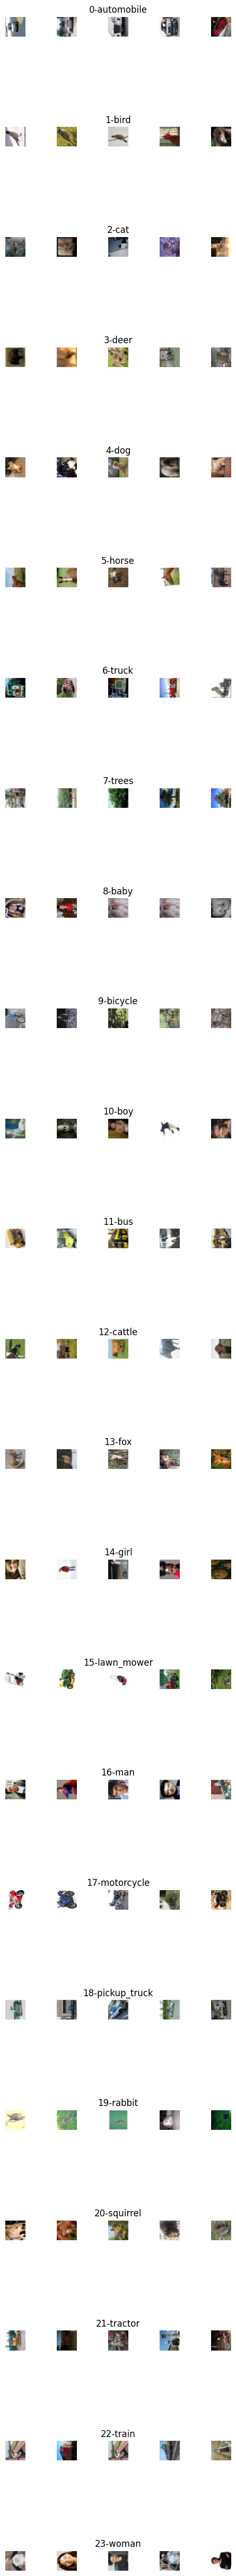

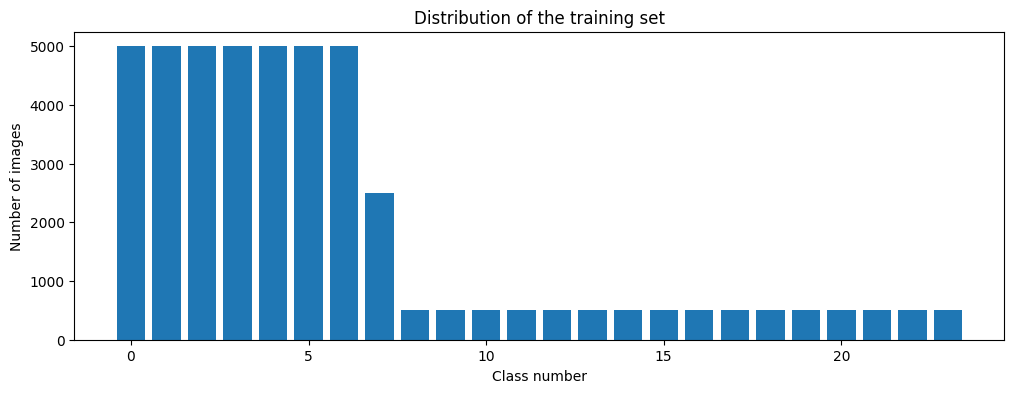

In [70]:
num_classes = len(set(y_train))
cols = 5
num_of_samples = show_all_class_samples(x_train, y_train, num_classes, cols)
show_class_distribution(num_of_samples, num_classes)

In [80]:
# Basic idea from ChatGPT
def detect_minor_class(x_train, y_train, majority_class_label_index, num_classes):
  minor_classes = [x_train[y_train == i] for i in range(num_classes) if i not in majority_class_label_index]
  minor_classes_labels = [y_train[y_train == i] for i in range(num_classes) if i not in majority_class_label_index]
  minor_classes = np.concatenate(minor_classes, axis=0)
  minor_classes_labels = np.concatenate(minor_classes_labels, axis=0)
  return minor_classes, minor_classes_labels

def merge_resampling_class(maj_class, maj_label, min_class, min_label):
  x_train = np.concatenate((maj_class, min_class), axis=0)
  y_train = np.concatenate((maj_label, min_label), axis=0)
  return x_train, y_train


def downsample_major_class(x_train, y_train, major_limit, num_classes):
  majority_class_label_index = {i for i in range(len(set(y_train))) if num_of_samples[i] > major_limit}

  majority_class = [x_train[y_train == i] for i in majority_class_label_index if (y_train == i).any()]
  majority_class_label = [y_train[y_train == i] for i in majority_class_label_index if (y_train == i).any()]
  downsampled_majority_class= []
  downsampled_majority_class_label = []
  desired_samples_count = 3000

  for i in majority_class_label_index:
    downsampled_data, downsampled_labels = resample(majority_class[i], majority_class_label[i], replace=False, n_samples=desired_samples_count)
    downsampled_majority_class.append(downsampled_data)
    downsampled_majority_class_label.append(downsampled_labels)

  downsampled_majority_class = np.concatenate(downsampled_majority_class, axis=0)
  downsampled_majority_class_label = np.concatenate(downsampled_majority_class_label, axis=0)

  minor_classes, minor_classes_labels = detect_minor_class(x_train, y_train, majority_class_label_index, num_classes)
  x_train, y_train = merge_resampling_class(downsampled_majority_class, downsampled_majority_class_label, minor_classes, minor_classes_labels)
  return x_train, y_train


In [72]:
def shuffle_data(x_train, y_train):
  shuffle_indices = np.random.permutation(len(x_train))
  x_train = x_train[shuffle_indices]
  y_train = y_train[shuffle_indices]
  return x_train, y_train

In [81]:
x_train, y_train = downsample_major_class(x_train, y_train, 3000, num_classes)
print(x_train.shape, y_train.shape)
print(set(y_train), y_train)
x_train, y_train = shuffle_data(x_train, y_train)
print(x_train.shape, y_train.shape)
print(set(y_train), y_train)

(31500, 3072) (31500,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} [ 0  0  0 ... 23 23 23]
(31500, 3072) (31500,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} [ 7  4 10 ...  7  4 18]


[3000, 3000, 3000, 3000, 3000, 3000, 3000, 2500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


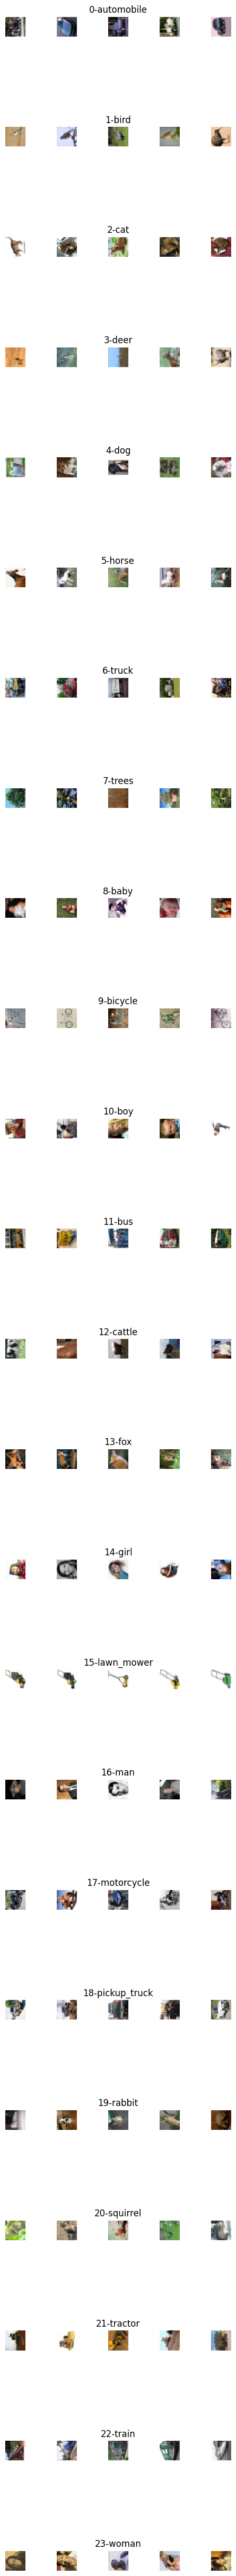

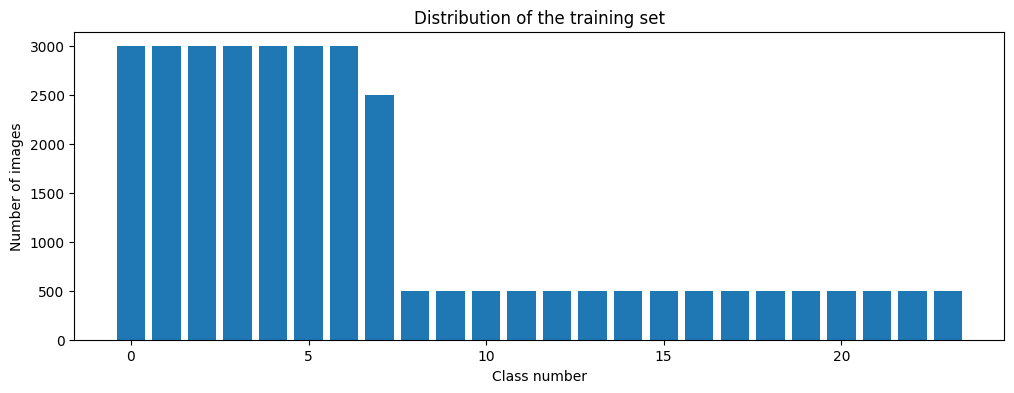

In [82]:
num_of_samples = show_all_class_samples(x_train, y_train, num_classes, cols)
show_class_distribution(num_of_samples, num_classes)

16


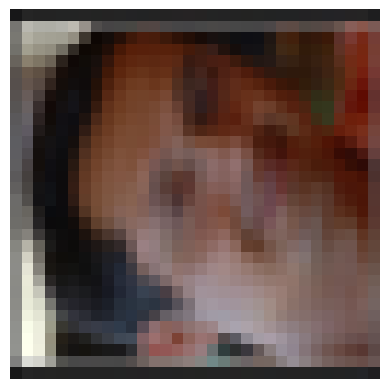

In [83]:
image = x_train[1000]
print(y_train[1000])
plt.imshow(load_image(image))
plt.axis('off')
plt.show()


(-0.5, 31.5, 31.5, -0.5)

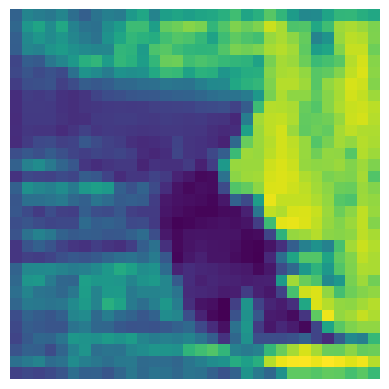

In [84]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img


img = grayscale(load_image(x_train[100]))
plt.imshow(img)
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

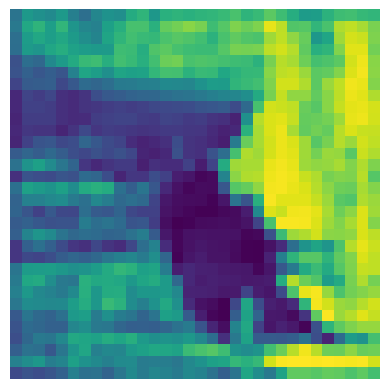

In [85]:

def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

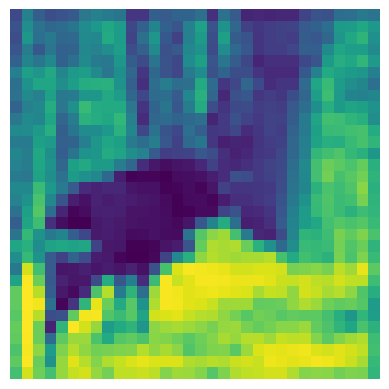

In [86]:
def rotate(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img


img = rotate(img)
plt.imshow(img)
plt.axis('off')

In [87]:
def preprocess(img):
  img = load_image(img)
  img = grayscale(img)
  img = equalize(img)
  img = rotate(img)
  img = img/255
  return img

In [88]:
rd_index = random.randint(0, (len(x_train)-1))
label = y_train[rd_index]
img = x_train[rd_index]

In [89]:
# Reshape whole image datasets
x_train = np.array(list(map(preprocess, x_train)))
x_test = np.array(list(map(preprocess, x_test)))

1 bird


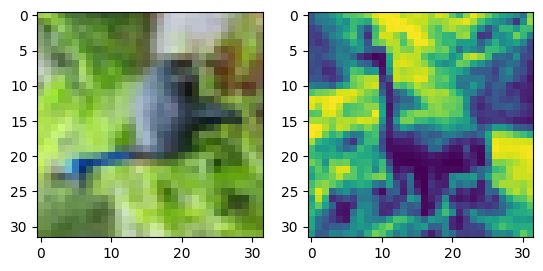

In [90]:
print(label, dic_classnames[label])
plt.subplot(1, 2, 1)
plt.imshow(load_image(img))
plt.subplot(1, 2, 2)
plt.imshow(x_train[rd_index])

In [91]:
def one_hot_encode_labels(y_train, y_val, y_test, num_classes):
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    y_val = to_categorical(y_val, num_classes)
    return y_train, y_val, y_test

In [92]:
def label_shape_match(x_train, y_train, x_val, y_val, x_test, y_test):
    assert(x_train.shape[0] == y_train.shape[0]), "The number of training images is not equal to the number of training labels"
    assert(x_test.shape[0] == y_test.shape[0]), "The number of test images is not equal to the number of test labels"
    assert(x_val.shape[0] == y_val.shape[0]), "The number of test images is not equal to the number of test labels"
    assert(x_train.shape[1:] == (32, 32)), "The training images are not 32x32"
    assert(x_test.shape[1:] == (32, 32)), "The test images are not 32x32"
    assert(x_val.shape[1:] == (32, 32)), "The valid images are not 32x32"


In [93]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [94]:
y_train, y_val, y_test = one_hot_encode_labels(y_train, y_val, y_test, num_classes)
label_shape_match(x_train, y_train, x_val, y_val, x_test, y_test)

In [95]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

In [96]:
# GTS_SD4B_23.ipynb (johnloane-repo)
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range=10)
datagen.fit(x_train)
batches = datagen.flow(x_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

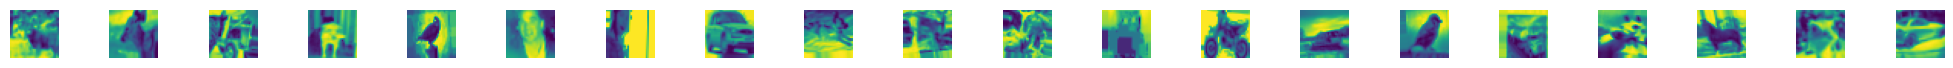

In [97]:
fig, axs = plt.subplots(1, 20, figsize=(20, 5))
fig.tight_layout()
for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [98]:
# GTS_SD4B_23.ipynb (johnloane-repo)
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [101]:
model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 60)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 30)        16230     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 30)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1080)              0         
                                                                 
 dense (Dense)               (None, 500)               5

In [103]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=x_train.shape[0]/50, epochs=15, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Epoch 1/15
504/504 [==============================] - 63s 123ms/step - loss: 2.6061 - accuracy: 0.2154 - val_loss: 2.2817 - val_accuracy: 0.3313
Epoch 2/15
504/504 [==============================] - 70s 140ms/step - loss: 2.3708 - accuracy: 0.2927 - val_loss: 2.1777 - val_accuracy: 0.3549
Epoch 3/15
504/504 [==============================] - 60s 119ms/step - loss: 2.2705 - accuracy: 0.3260 - val_loss: 2.0945 - val_accuracy: 0.3830
Epoch 4/15
504/504 [==============================] - 61s 120ms/step - loss: 2.1805 - accuracy: 0.3503 - val_loss: 1.9671 - val_accuracy: 0.4171
Epoch 5/15
504/504 [==============================] - 62s 123ms/step - loss: 2.1119 - accuracy: 0.3733 - val_loss: 1.8805 - val_accuracy: 0.4348
Epoch 6/15
504/504 [==============================] - 61s 122ms/step - loss: 2.0420 - accuracy: 0.3943 - val_loss: 1.8143 - val_accuracy: 0.4624
Epoch 7/15
504/504 [==============================] - 60s 120ms/step - loss: 1.9876 - accuracy: 0.4105 - val_loss: 1.7799 - val_ac

Text(0.5, 0, "'epoch")

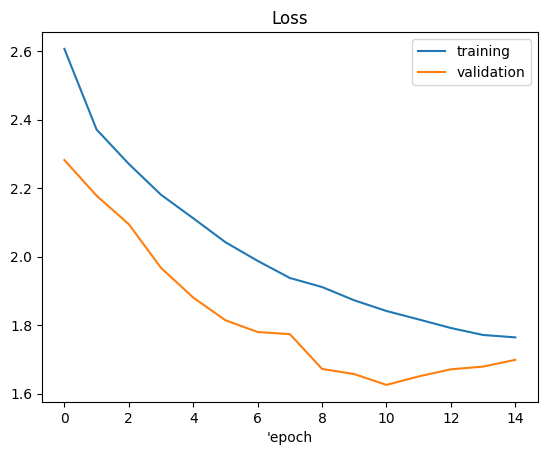

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("'epoch")

In [105]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

285/285 [==============================] - 4s 15ms/step - loss: 1.6048 - accuracy: 0.5110
Test score:  1.6047872304916382
Test accuracy:  0.5109890103340149


In [ ]:
# IDEA:
# for superclass, change all fine_labels corresponding to superclass into one label (for avoiding label duplication, number >= 100)

# Preprocesing:
# Undersampling classes with sufficient samples
# Apply data argumentation
# Image is already 32x32x3, downscaling may lead to more information loss of the image
# Mapping to grey scale -> (32, 32, 1)
# Contrast are not high, increase the contrasts

# print("Predicted sign: " + str(np.argmax(model.predict(img), axis=-1)))